跑一个 cifar-10 的 demo 看看

先把 cifar-10 的数据引入进来

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# dir(os.environ)

定义数据集

In [2]:
transform = transforms.Compose(
    [
        transforms.Scale(244),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=20,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

出几张图看一看

  cat   cat   dog   car   car  bird   car  ship   cat truck


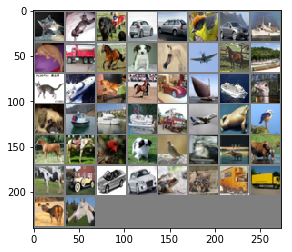

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

定义 net

In [3]:
import torchvision.models as models
import torch.nn as nn

# net = models.alexnet()
# net = models.vgg11()
# net = models.resnet18()
net = models.densenet121()

# net = net.cuda()
# net = nn.DataParallel(net).cuda()

# 加载之前的参数
# net.load_state_dict( torch.load('resnet18_cifar10_epoch15_params.pkl') )

net = nn.DataParallel(net).cuda()
# print('alexnet', net)

定义神经网络

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net = net.cuda()
print(net)

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


定义一个损失函数

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

adjust Learning Rate

In [5]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Train the network

In [6]:
%%time
# import time
# t1 = time.time()

for epoch in range(30):  # loop over the dataset multiple times

    scheduler.step()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
#         scheduler.step()
        
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
#         inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            print([param_group["lr"] for param_group in optimizer.param_groups])


# print('Finished Training', time.time() - t1)

[1,  1000] loss: 1.734
[0.1]
[2,  1000] loss: 1.105
[0.1]
[3,  1000] loss: 0.785
[0.1]
[4,  1000] loss: 0.594
[0.1]
[5,  1000] loss: 0.491
[0.1]
[6,  1000] loss: 0.396
[0.1]
[7,  1000] loss: 0.341
[0.1]
[8,  1000] loss: 0.282
[0.1]
[9,  1000] loss: 0.236
[0.1]
[10,  1000] loss: 0.197
[0.1]
[11,  1000] loss: 0.089
[0.010000000000000002]
[12,  1000] loss: 0.053
[0.010000000000000002]
[13,  1000] loss: 0.039
[0.010000000000000002]
[14,  1000] loss: 0.030
[0.010000000000000002]
[15,  1000] loss: 0.024
[0.010000000000000002]
[16,  1000] loss: 0.021
[0.010000000000000002]
[17,  1000] loss: 0.017
[0.010000000000000002]
[18,  1000] loss: 0.015
[0.010000000000000002]
[19,  1000] loss: 0.012
[0.010000000000000002]
[20,  1000] loss: 0.012
[0.010000000000000002]
[21,  1000] loss: 0.010
[0.0010000000000000002]
[22,  1000] loss: 0.009
[0.0010000000000000002]
[23,  1000] loss: 0.009
[0.0010000000000000002]
[24,  1000] loss: 0.009
[0.0010000000000000002]
[25,  1000] loss: 0.009
[0.0010000000000000002]

Test the network on the test data

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car


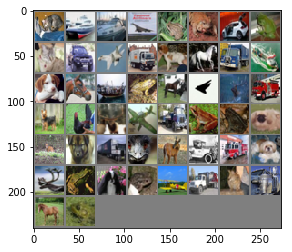

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# labels = labels.cuda()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

看看神经网络认为它们是什么

In [10]:
outputs = net(Variable(images.cuda()))

预测结果

In [12]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


结果不错的样子啊，看看整个测试集的预测结果

In [7]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


把参数保存起来

In [8]:
torch.save(net.state_dict(), '../net_state/densenet121_cifar10_epoch30_params.pkl')

In [2]:
3680 / 46

80.0

In [ ]:
9